In [1]:
import datetime
import pathlib
import typing
import collections

import humanize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from deeplearning.clgen import clgen
from deeplearning.clgen.corpuses import corpuses
from deeplearning.clgen.proto import corpus_pb2
from deeplearning.clgen.proto import clgen_pb2
from deeplearning.clgen.proto import model_pb2
from deeplearning.clgen.proto import sampler_pb2
from deeplearning.clgen import clgen
from lib.labm8 import bazelutil
from lib.labm8 import pbutil
from lib.labm8 import viz

In [2]:
working_dir = '/var/phd/clgen/baseline'

def InstanceConfigs(language: str, model: str, temperature: str) -> typing.Dict[str, str]:
    return {
        'corpus': bazelutil.DataPath(f'phd/experimental/polyglot/baselines/corpuses/{language}-char.pbtxt'),
        'model': bazelutil.DataPath(f'phd/experimental/polyglot/baselines/models/{model}.pbtxt'),
        'sampler': bazelutil.DataPath(f'phd/experimental/polyglot/baselines/samplers/{language}-{temperature}.pbtxt'),
    }

instance_configs = [
    InstanceConfigs('opencl', '32-512x2-adam', '1.0'),
    InstanceConfigs('opencl', '32-1024x2-adam', '1.0'),
    InstanceConfigs('opencl', '64-512x2-adam', '1.0'),
    InstanceConfigs('opencl', '64-1024x2-adam', '1.0'),
    InstanceConfigs('opencl', '128-512x2-adam', '1.0'),
    InstanceConfigs('opencl', '128-1024x2-adam', '1.0'),
]

In [3]:
def InstanceFromConfigs(config_paths):
    corpus_config = pbutil.FromFile(config_paths['corpus'], corpus_pb2.Corpus())
    model_config = pbutil.FromFile(config_paths['model'], model_pb2.Model())
    sampler_config = pbutil.FromFile(config_paths['sampler'], sampler_pb2.Sampler())
    model_config.corpus.CopyFrom(corpus_config)
    return clgen.Instance(
        clgen_pb2.Instance(working_dir=working_dir, model=model_config, sampler=sampler_config))

instances = [InstanceFromConfigs(config_paths) for config_paths in instance_configs]
print("Loaded {} instances".format(len(instances)))

Loaded 6 instances


In [4]:
def GetOutputCorpus(instance: clgen.Instance) -> corpuses.Corpus:
    out_dir = pathlib.Path(
        str(instance.model.SamplerCache(instance.sampler)) + '.postprocessed')
    if not out_dir.is_dir():
        return None
    output_corpus_config = corpus_pb2.Corpus()
    output_corpus_config.CopyFrom(instance.model.corpus.config)
    output_corpus_config.local_directory = str(out_dir)
    return corpuses.Corpus(output_corpus_config)

output_corpuses = [GetOutputCorpus(i) for i in instances]
print("Loaded {} output corpuses".format(len([x for x in output_corpuses if x])))

Loaded 2 output corpuses


In [9]:
def InstanceStats(instance: clgen.Instance, output_corpus: corpuses.Corpus) -> typing.Dict[str, typing.Any]:
    stats = collections.OrderedDict()
    stats['Language'] = {
        'opencl': 'OpenCL',
        'java': 'Java',
    }[pathlib.Path(instance.model.corpus.config.local_directory).stem]
    instance.model.corpus.Create()
    stats['Encoding'] = 'Character' if 'Ascii' in str(instance.model.corpus.atomizer) else 'Token'
    stats['Vocab size'] = instance.model.corpus.atomizer.vocab_size
    stats['Corpus size'] = '{:.1f}M'.format(instance.model.corpus.encoded.token_count / 1e6)
    stats['Embedding'] = instance.model.config.architecture.embedding_size
    stats['Model size'] = f'{instance.model.config.architecture.neurons_per_layer}x{instance.model.config.architecture.num_layers}'
    stats['Dropout'] = instance.model.config.architecture.post_layer_dropout_micros / 1e6
    if instance.model.config.training.HasField('adam_optimizer'):
        stats['Optimizer'] = 'Adam'
        stats['Learning rate'] = instance.model.config.training.adam_optimizer.initial_learning_rate_micros / 1e6
        stats['Decay'] = instance.model.config.training.adam_optimizer.learning_rate_decay_per_epoch_micros / 1e6
    else:
        stats['Optimizer'] = 'RMSProp'
        stats['Learning rate'] = instance.model.config.training.rmsprop_optimizer.initial_learning_rate_micros / 1e6
        stats['Decay'] = instance.model.config.training.rmsprop_optimizer.learning_rate_decay_per_epoch_micros / 1e6
    telemetry = instance.model.TrainingTelemetry()
    if telemetry:
        stats['Epochs'] = len(telemetry)
        stats['Final Loss'] = '{:.3f}'.format(telemetry[-1].loss)
        stats['Training time'] = humanize.naturaldelta(
            datetime.timedelta(seconds=sum(t.epoch_wall_time_ms for t in telemetry) / 1e3))
        stats['Time / epoch'] = humanize.naturaldelta(
            datetime.timedelta(seconds=np.array([t.epoch_wall_time_ms for t in telemetry]).mean() / 1e3))

    if output_corpus:
        samples_dir = instance.model.SamplerCache(instance.sampler)
        sample_times = np.array([
            pbutil.FromFile(samples_dir / f, model_pb2.Sample, uninitialized_okay=True).wall_time_ms for f in samples_dir.iterdir()
        ], dtype=np.int32)
        # TODO(cec): Use the number of extracted kernels, not the number of samples themselves.
        stats['Output samples'] = humanize.intcomma(len(sample_times))
        # Sample times is in milliseconds, and we want time per thousand, so they cancel out.
        stats['Time / 1k samples'] = humanize.naturaldelta(
            datetime.timedelta(seconds=sample_times.mean()))
        stats['Efficiency'] = '{:.2%}'.format(
            output_corpus.preprocessed.size / (output_corpus.preprocessed.input_size or 1))
    # TODO(cec):
    # * Post process discard ratio
    # * Time / 1k good samples
    return stats

stats = pd.DataFrame([InstanceStats(i, o) for i, o in zip(instances, output_corpuses)]).fillna('-')
stats

,Language,Encoding,Vocab size,Corpus size,Embedding,Model size,Dropout,Optimizer,Learning rate,Decay,Epochs,Final Loss,Training time,Time / epoch,Output samples,Time / 1k samples,Efficiency
0,OpenCL,Character,92,21.8M,32,512x2,0.2,Adam,0.001,0.0,-,-,-,-,-,-,-
1,OpenCL,Character,92,21.8M,32,1024x2,0.2,Adam,0.001,0.0,-,-,-,-,-,-,-
2,OpenCL,Character,92,21.8M,64,512x2,0.2,Adam,0.001,0.0,50,0.162,13 hours,16 minutes,"5,000",30 minutes,0.00%
3,OpenCL,Character,92,21.8M,64,1024x2,0.2,Adam,0.001,0.0,50,0.119,16 hours,20 minutes,"5,000",28 minutes,0.00%
4,OpenCL,Character,92,21.8M,128,512x2,0.2,Adam,0.001,0.0,-,-,-,-,-,-,-
5,OpenCL,Character,92,21.8M,128,1024x2,0.2,Adam,0.001,0.0,-,-,-,-,-,-,-


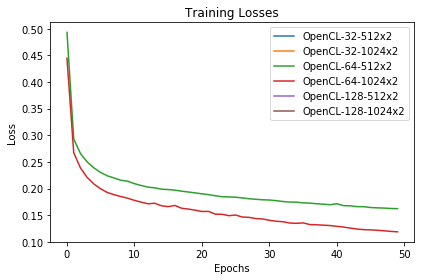

In [6]:
for (_, row), instance in zip(stats.iterrows(), instances):
    losses = [t.loss for t in instance.model.TrainingTelemetry()]
    plt.plot(range(len(losses)), losses, label=f"{row['Language']}-{row['Embedding']}-{row['Model size']}")

ax = plt.gca()
plt.title('Training Losses')

# X axis.
# plt.xlim((0, 50 - 1))
# ax.set_xticklabels([i + 1 for i in ax.get_xticks()])
plt.xlabel('Epochs')

# Y axis.
plt.ylabel('Loss')

plt.legend()
viz.finalise(size=(10, 8))